In [1]:
# necessary imports
import os
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy

%matplotlib inline

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# chek if cuda is set up -> if GPU is available, it works
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Reading data
Now the data shall be read in. The tensorflow ImageDataGenerator is used. This function will fetch the data and feed it to the network when requested. Advantage: It's not going to load and augment all data at once (which could consume a lot of memory), but one-by-one. This requires less memory, but more training time.

In [3]:
# create folder where the trained model can be stored later
path = os.getcwd()
model_path = os.path.join(path, 'Trained_Model')

if not os.path.exists(model_path):
    os.makedirs(model_path)

In [4]:
# set parameters of images such that they fit to ResNet-50 model which will be used for training (224, 224, 3)
img_width, img_height = 224, 224

train_data_dir = os.path.join(path, r'train')
test_data_dir = os.path.join(path, r'test')

batch_size = 8

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 24 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [6]:
def extract_labels(data_path):
    ''' this function returns a list of labels corresponding to the path provided '''
    return os.listdir(data_path)

def get_label(label_categorical, class_list):
    '''
    this fucntion returns the name of the label corresponding the the provided category 
    
    Inputs:
        1) : label_categorical (numpy array) : categorical array containing only a 1 for the selected label
        2) : class_list (list of strings) : list of strings containing the class names (extracted form the directory)
        
    Outputs:
        returns the string containing the correct class name
    '''
    # get index where label_categorical contains the 1
    index = np.where(label_categorical == 1)[0][0]
    # get label from class list using the index and return it
    return class_list[index]

Text(0.5, 1.0, 'pd')

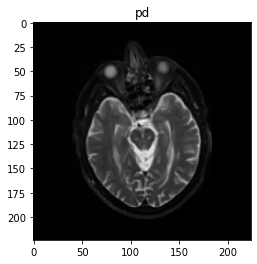

In [7]:
# print one example image and it's corresponding label from training set
batch_nr = 0
img_nr = np.random.choice(np.arange(0, batch_size))

# get list of class names
class_list = extract_labels(train_data_dir)

# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
train_batch_tuple = train_generator[batch_nr]
train_batch_data = train_batch_tuple[0]
train_batch_label = train_batch_tuple[1]

# now: get label name
class_name = get_label(train_batch_label[img_nr], class_list)

# now: plot image and set title to corresponding label
img = train_batch_data[img_nr]
plt.imshow(img)
plt.title(class_name)

## Load and compile pretrained Model

In [8]:
# include_top false to not include the last fully connected layer
model_res50 = applications.ResNet50(weights='imagenet', include_top=False) 

In [9]:
# get netowrk architecture
model_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [10]:
# add a global spatial average pooling layer
x = model_res50.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)

# and a fully connected output/classification layer
predictions = Dense(2, activation='softmax')(x)

# create the full network so we can train on it
model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [11]:
# get new network architecture
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [12]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# check locally avaiable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8042559703280549319
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1342461528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11893216923081467594
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


In [14]:
with tf.device("/device:GPU:0"):
    history_pretrained = model_transfer.fit(
    train_generator,
    epochs=5, shuffle = True, verbose = 1, validation_data = test_generator)

Epoch 1/5
3/3 [==============================] - 29s 3s/step - loss: 0.8836 - accuracy: 0.5833 - val_loss: 0.7175 - val_accuracy: 0.2000
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 0.7436 - accuracy: 0.5833 - val_loss: 0.7212 - val_accuracy: 0.2000
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 0.5407 - accuracy: 0.7917 - val_loss: 0.7217 - val_accuracy: 0.2000
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 0.4510 - accuracy: 0.9167 - val_loss: 0.7196 - val_accuracy: 0.2000
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 0.4193 - accuracy: 0.8333 - val_loss: 0.7138 - val_accuracy: 0.2667


In [15]:
model_name = 'my_model.h5'
model_path_new = os.path.join(model_path, model_name)

In [16]:
# save full model for later reusage
model_transfer.save(model_path_new)
# load it later using "new_model = tf.keras.models.load_model(model_path_new)""

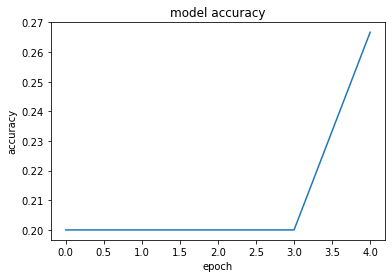

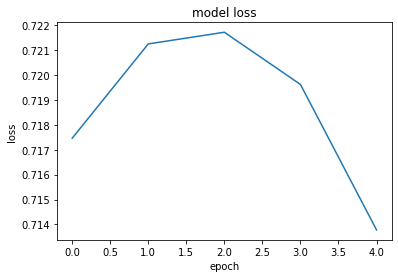

In [17]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()